In [1]:
!pip uninstall keras -y

Found existing installation: keras 3.3.3
Uninstalling keras-3.3.3:
  Successfully uninstalled keras-3.3.3


In [2]:
!pip install ultralytics
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.1/877.1 kB 20.5 MB/s eta 0:00:0000:01
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [3]:
pip install tensorflow tensorflow-datasets matplotlib opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install torch torchvision albumentations

Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install opendatasets --upgrade

In [6]:
import opendatasets as od
import cv2
import imghdr
import tensorflow as tf
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

In [7]:
#Load the data from kaggle
image_path = "https://www.kaggle.com/datasets/anasmohammedtahir/covidqu"

{"username":"ibebenedict","key":"f9402928d7dce1078c5310e48dfb2874"}

In [8]:
od.download(image_path)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  ibebenedict


Your Kaggle Key:

  ································


Dataset URL: https://www.kaggle.com/datasets/anasmohammedtahir/covidqu


100%|██████████| 1.15G/1.15G [00:13<00:00, 91.2MB/s]


In [9]:
IMAGE_SIZE = 224
BATCH_SIZE = 150
labels = ["Lung", "Infection"]

TRAIN_DIR = '/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train'
TEST_DIR = '/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test'
VALID_DIR = '/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val'


In [10]:
import os
import pandas as pd

# Assuming the dataset is located in 'covidqu_sample' after using od.download
dataset_path = '/kaggle/working/covidqu/Infection Segmentation Data/Infection Segmentation Data'

# Initialize an empty list to store data
data = []

# Define the class labels
labels = ['COVID-19', 'Non-COVID', 'Normal']

# Iterate over the dataset directory structure and gather file paths and metadata
for data_type in ['Test', 'Train', 'Val']:  # Iterate over Test, Train, and Val
    for label in labels:
        # Directories for original images and infection masks
        original_images_dir = os.path.join(dataset_path, data_type, label, 'images')
        infection_masks_dir = os.path.join(dataset_path, data_type, label, 'infection masks') if label == 'COVID-19' else None
        
        if os.path.exists(original_images_dir):
            for filename in os.listdir(original_images_dir):
                if filename.endswith('.png'):  # Process only image files
                    original_image_path = os.path.join(original_images_dir, filename)
                    
                    # Only COVID-19 has infection masks; for others, masks are empty (None)
                    infection_mask_path = os.path.join(infection_masks_dir, filename) if infection_masks_dir and os.path.exists(infection_masks_dir) else None
                    
                    # Append the details to the list
                    data.append({
                        'Original_Image_Path': original_image_path,
                        'Infection_Mask_Path': infection_mask_path,
                        'Label': label
                    })

# Convert the list of data to a DataFrame
df_covid_images = pd.DataFrame(data)

# Display the DataFrame
df_covid_images.head()

,Original_Image_Path,Infection_Mask_Path,Label
0,/kaggle/working/covidqu/Infection Segmentation...,/kaggle/working/covidqu/Infection Segmentation...,COVID-19
1,/kaggle/working/covidqu/Infection Segmentation...,/kaggle/working/covidqu/Infection Segmentation...,COVID-19
2,/kaggle/working/covidqu/Infection Segmentation...,/kaggle/working/covidqu/Infection Segmentation...,COVID-19
3,/kaggle/working/covidqu/Infection Segmentation...,/kaggle/working/covidqu/Infection Segmentation...,COVID-19
4,/kaggle/working/covidqu/Infection Segmentation...,/kaggle/working/covidqu/Infection Segmentation...,COVID-19


In [11]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Set image dimensions
IMG_HEIGHT, IMG_WIDTH = 128, 128

# Function to load and preprocess images and masks
def load_image(image_path, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
    if image is None:
        print(f"Error loading image: {image_path}")
        return None
    
    image = cv2.resize(image, (img_height, img_width))  # Resize image
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    return image / 255.0  # Normalize the pixel values

def load_data(df):
    images = []
    masks = []
    
    for index, row in df.iterrows():
        # Load original image
        original_image = load_image(row['Original_Image_Path'])
        
        # Handle missing infection masks (Non-COVID and Normal classes)
        if pd.isna(row['Infection_Mask_Path']):
            infection_mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1))  # Create an empty mask for Non-COVID/Normal
        else:
            infection_mask = load_image(row['Infection_Mask_Path'])
        
        # If either image or mask couldn't be loaded, skip this record
        if original_image is None or infection_mask is None:
            continue
        
        images.append(original_image)
        masks.append(infection_mask)
    
    return np.array(images), np.array(masks)

# Load the dataframe (df_covid_images) containing paths to images and masks
# Ensure df_covid_images is created as per the previous step

# Load the dataset (split into train and test sets)
X, y = load_data(df_covid_images)

# Check if data is loaded
if len(X) == 0 or len(y) == 0:
    raise ValueError("No images or masks loaded. Please check your data.")

# Split the dataset into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the U-Net model
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 1)):
    inputs = Input(input_size)

    # Encoding path (downsampling)
    c1 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, kernel_size=3, activation='relu', padding='same')(p3)
    c4 = Conv2D(512, kernel_size=3, activation='relu', padding='same')(c4)

    # Decoding path (upsampling)
    u1 = Conv2DTranspose(256, kernel_size=3, strides=(2, 2), padding='same')(c4)
    u1 = concatenate([u1, c3])
    c5 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(u1)
    c5 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(c5)

    u2 = Conv2DTranspose(128, kernel_size=3, strides=(2, 2), padding='same')(c5)
    u2 = concatenate([u2, c2])
    c6 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(u2)
    c6 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(c6)

    u3 = Conv2DTranspose(64, kernel_size=3, strides=(2, 2), padding='same')(c6)
    u3 = concatenate([u3, c1])
    c7 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(u3)
    c7 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(c7)

    # Output layer (single channel for binary classification)
    outputs = Conv2D(1, kernel_size=1, activation='sigmoid')(c7)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Compile the model
model = unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 1))
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the U-Net model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16)

# After training, the model can be saved and further evaluated if needed.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  1,179,904 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,179,904 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │    295,040 │ conv2d_9[0][0]  

 Total params: 8,556,353 (32.64 MB)

 Trainable params: 8,556,353 (32.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


I0000 00:00:1729789411.436533     154 service.cc:145] XLA service 0x59beb7865e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729789411.436587     154 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729789411.436592     154 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1729789434.886827     154 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


292/292 ━━━━━━━━━━━━━━━━━━━━ 98s 240ms/step - accuracy: 0.9089 - loss: 0.2682 - val_accuracy: 0.9274 - val_loss: 0.1891
Epoch 2/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 49s 168ms/step - accuracy: 0.9251 - loss: 0.1834 - val_accuracy: 0.9286 - val_loss: 0.1688
Epoch 3/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 49s 169ms/step - accuracy: 0.9299 - loss: 0.1574 - val_accuracy: 0.9318 - val_loss: 0.1585
Epoch 4/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 49s 169ms/step - accuracy: 0.9386 - loss: 0.1386 - val_accuracy: 0.9487 - val_loss: 0.1167
Epoch 5/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 49s 169ms/step - accuracy: 0.9457 - loss: 0.1209 - val_accuracy: 0.9510 - val_loss: 0.1136
Epoch 6/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 49s 168ms/step - accuracy: 0.9497 - loss: 0.1101 - val_accuracy: 0.9533 - val_loss: 0.1026
Epoch 7/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 49s 169ms/step - accuracy: 0.9546 - loss: 0.0995 - val_accuracy: 0.9537 - val_loss: 0.1027
Epoch 8/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 49s 169ms/step - accuracy: 0.9599 - loss: 0.0873 - val

In [12]:
# Save the trained model
model.save('Ben_covid_unet_segmentation_model.h5')

# Model evaluation on validation set
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Predict on new images (for future X-ray images)
def predict_segmentation(image_path):
    # Preprocess the image
    original_image = load_image(image_path)
    original_image = np.expand_dims(original_image, axis=0)  # Add batch dimension
    
    # Predict infection mask
    predicted_mask = model.predict(original_image)
    
    # Reshape back to original size and threshold to binary mask
    predicted_mask = np.squeeze(predicted_mask)  # Remove batch dimension
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Convert to binary mask
    
    return predicted_mask

37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.9627 - loss: 0.1051
Validation Loss: 0.10791194438934326
Validation Accuracy: 0.9615198969841003


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Threshold the ground truth masks (y_val) to binary (0 or 1)
y_val_binary = (y_val > 0.5).astype(np.uint8)

# Predict on the validation set
y_pred = model.predict(X_val)

# Convert predictions to binary (threshold at 0.5)
y_pred_binary = (y_pred > 0.5).astype(np.uint8)

# Flatten the ground truth and predictions to calculate metrics
y_val_flat = y_val_binary.flatten()
y_pred_flat = y_pred_binary.flatten()

# Calculate accuracy
accuracy = accuracy_score(y_val_flat, y_pred_flat)
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = precision_score(y_val_flat, y_pred_flat)
print(f"Precision: {precision}")

# Calculate recall
recall = recall_score(y_val_flat, y_pred_flat)
print(f"Recall: {recall}")

# Calculate F1-Score
f1 = f1_score(y_val_flat, y_pred_flat)
print(f"F1-Score: {f1}")

# Calculate IoU (Intersection over Union)
intersection = np.logical_and(y_val_flat, y_pred_flat)
union = np.logical_or(y_val_flat, y_pred_flat)
iou = np.sum(intersection) / np.sum(union)
print(f"IoU: {iou}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step
Accuracy: 0.9642755367743622
Precision: 0.75900722722528
Recall: 0.729339481570008
F1-Score: 0.7438776655211663
IoU: 0.5922016073615967


In [60]:
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

# Function to calculate Average Precision (AP) for each image
def compute_average_precision(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true.flatten(), y_pred.flatten())
    return auc(recall, precision)  # Calculate the area under the precision-recall curve (AP)

# Function to compute mAP for the entire validation set
def compute_mAP(y_true, y_pred):
    ap_scores = []
    
    for i in range(len(y_true)):
        ap = compute_average_precision(y_true[i], y_pred[i])
        ap_scores.append(ap)
    
    mAP = np.mean(ap_scores)  # Mean of all the AP scores
    return mAP

# Threshold the ground truth masks (y_val) to binary (0 or 1)
y_val_binary = (y_val > 0.5).astype(np.uint8)

# Predict on the validation set
y_pred = model.predict(X_val)

# Convert predictions to binary (threshold at 0.5)
y_pred_binary = (y_pred > 0.5).astype(np.uint8)

# Compute the mAP for the U-Net model
mAP = compute_mAP(y_val_binary, y_pred_binary)
print(f"Mean Average Precision (mAP): {mAP}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class f

Mean Average Precision (mAP): 0.6203652355708399


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class f

In [61]:
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

# Function to calculate Average Precision (AP) for each image
def compute_average_precision(y_true, y_pred):
    # Only compute AP if the ground truth has positive pixels
    if np.sum(y_true) == 0:
        return None  # Skip cases with no positive pixels in the ground truth
    precision, recall, _ = precision_recall_curve(y_true.flatten(), y_pred.flatten())
    return auc(recall, precision)  # Calculate the area under the precision-recall curve (AP)

# Function to compute mAP for the entire validation set
def compute_mAP(y_true, y_pred):
    ap_scores = []
    
    for i in range(len(y_true)):
        ap = compute_average_precision(y_true[i], y_pred[i])
        if ap is not None:  # Only include non-None AP scores
            ap_scores.append(ap)
    
    if len(ap_scores) == 0:
        return 0.0  # If no valid AP scores were computed, return 0 mAP
    mAP = np.mean(ap_scores)  # Mean of all the AP scores
    return mAP

# Threshold the ground truth masks (y_val) to binary (0 or 1)
y_val_binary = (y_val > 0.5).astype(np.uint8)

# Predict on the validation set
y_pred = model.predict(X_val)

# Convert predictions to binary (threshold at 0.5)
y_pred_binary = (y_pred > 0.5).astype(np.uint8)

# Compute the mAP for the U-Net model
mAP = compute_mAP(y_val_binary, y_pred_binary)
print(f"Mean Average Precision (mAP): {mAP}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step
Mean Average Precision (mAP): 0.7366709353720056


In [14]:
model.save('covid_unet_segmentation_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


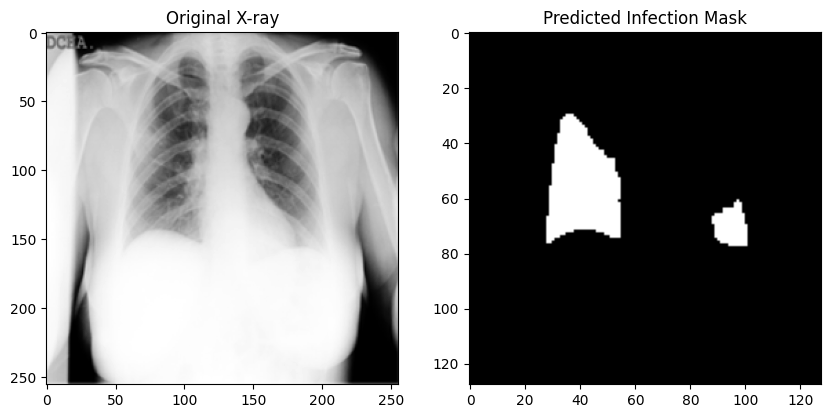

In [15]:
# Test prediction on a new X-ray image
test_image_path = df_covid_images.iloc[0]['Original_Image_Path']  # Example test
predicted_mask = predict_segmentation(test_image_path)

# Show original and predicted mask
import matplotlib.pyplot as plt

# Load the original image
original_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original X-ray')
plt.imshow(original_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Predicted Infection Mask')
plt.imshow(predicted_mask, cmap='gray')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


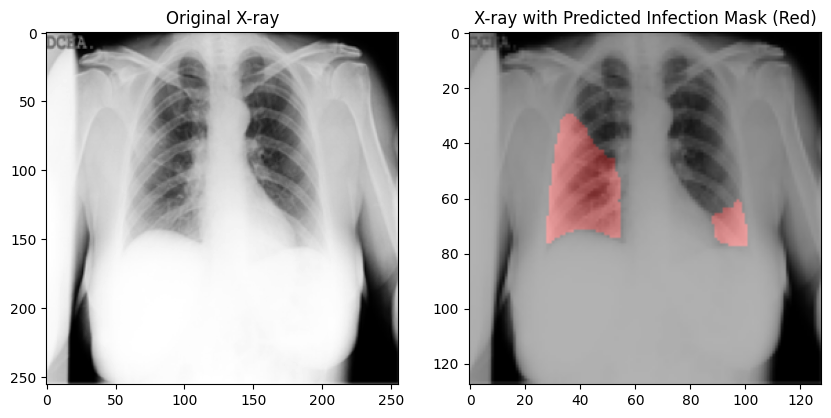

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to superimpose the infection mask on the original X-ray image
def superimpose_mask_on_xray(original_image, predicted_mask):
    # Ensure the original image and mask are the same size
    original_image_resized = cv2.resize(original_image, (predicted_mask.shape[1], predicted_mask.shape[0]))
    
    # Convert the original grayscale X-ray to RGB for overlaying
    original_image_rgb = cv2.cvtColor(original_image_resized, cv2.COLOR_GRAY2RGB)
    
    # Create a 3-channel (RGB) version of the predicted mask with red color for infected areas
    mask_rgb = np.zeros_like(original_image_rgb)
    mask_rgb[:, :, 0] = predicted_mask * 255  # Red channel, apply mask to highlight red
    
    # Superimpose the mask on the original image
    superimposed_image = cv2.addWeighted(original_image_rgb, 0.7, mask_rgb, 0.3, 0)
    
    return superimposed_image

# Load the original image (grayscale) and predicted mask
test_image_path = df_covid_images.iloc[0]['Original_Image_Path']  # Example test
original_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

# Predict the mask for the test image
predicted_mask = predict_segmentation(test_image_path)

# Superimpose the predicted mask on the original X-ray
superimposed_image = superimpose_mask_on_xray(original_image, predicted_mask)

# Show the original X-ray and the superimposed image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original X-ray')
plt.imshow(original_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('X-ray with Predicted Infection Mask (Red)')
plt.imshow(superimposed_image)

plt.show()

In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Assume 'uploaded_image_path' contains the path to the uploaded image
uploaded_image_path = '/kaggle/input/testingdata/4-x-day1.jpg'  # Replace with the actual path of the uploaded image

# Function to preprocess the uploaded image
def load_and_preprocess_image(image_path, img_height=128, img_width=128):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    
    # Resize the image to the size used for training
    image = cv2.resize(image, (img_height, img_width))
    
    # Normalize the pixel values (scaling to range [0, 1])
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = image / 255.0  # Normalize the image
    return np.expand_dims(image, axis=0)  # Add batch dimension

# Preprocess the uploaded image
preprocessed_image = load_and_preprocess_image(uploaded_image_path)

# Predict the infection mask using the saved model
predicted_mask = model.predict(preprocessed_image)

# Reshape and threshold the predicted mask to binary
predicted_mask = np.squeeze(predicted_mask)  # Remove batch dimension
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Convert to binary mask (0 or 1)

# Load the original image for comparison (without resizing)
original_image = cv2.imread(uploaded_image_path, cv2.IMREAD_GRAYSCALE)

# Show the original image and predicted infection mask side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original X-ray')
plt.imshow(original_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Predicted Infection Mask')
plt.imshow(predicted_mask, cmap='gray')

plt.show()

[ WARN:0@1252.643] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/testingdata/4-x-day1.jpg'): can't open/read file: check file path/integrity


FileNotFoundError: Image not found at path: /kaggle/input/testingdata/4-x-day1.jpg

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Assume 'uploaded_image_path' contains the path to the uploaded image
uploaded_image_path = '/kaggle/working/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val/Non-COVID/images/non_COVID (5010).png'  # Replace with the actual path of the uploaded image

# Function to preprocess the uploaded image
def load_and_preprocess_image(image_path, img_height=128, img_width=128):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    
    # Resize the image to the size used for training
    image = cv2.resize(image, (img_height, img_width))
    
    # Normalize the pixel values (scaling to range [0, 1])
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = image / 255.0  # Normalize the image
    return np.expand_dims(image, axis=0)  # Add batch dimension

# Preprocess the uploaded image
preprocessed_image = load_and_preprocess_image(uploaded_image_path)

# Predict the infection mask using the saved model
predicted_mask = model.predict(preprocessed_image)

# Reshape and threshold the predicted mask to binary
predicted_mask = np.squeeze(predicted_mask)  # Remove batch dimension
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Convert to binary mask (0 or 1)

# Load the original image (not resized) for superimposing the predicted mask
original_image = cv2.imread(uploaded_image_path, cv2.IMREAD_GRAYSCALE)

# Function to superimpose the infection mask on the original X-ray image
def superimpose_mask_on_xray(original_image, predicted_mask):
    # Resize the original image to match the mask size
    original_image_resized = cv2.resize(original_image, (predicted_mask.shape[1], predicted_mask.shape[0]))
    
    # Convert the original grayscale X-ray to RGB for overlaying
    original_image_rgb = cv2.cvtColor(original_image_resized, cv2.COLOR_GRAY2RGB)
    
    # Create a 3-channel (RGB) version of the predicted mask with red color for infected areas
    mask_rgb = np.zeros_like(original_image_rgb)
    mask_rgb[:, :, 0] = predicted_mask * 255  # Red channel, apply mask to highlight red
    
    # Superimpose the mask on the original image
    superimposed_image = cv2.addWeighted(original_image_rgb, 0.7, mask_rgb, 0.3, 0)
    
    return superimposed_image

# Superimpose the predicted mask on the original X-ray
superimposed_image = superimpose_mask_on_xray(original_image, predicted_mask)

# Show the original X-ray and the superimposed image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original X-ray')
plt.imshow(original_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('X-ray with Predicted Infection Mask (Red)')
plt.imshow(superimposed_image)

plt.show()

CLIP MODEL

In [18]:
import os
import pandas as pd

# Assuming the dataset is located in 'covidqu_sample' after using od.download
dataset_path = '/kaggle/working/covidqu/Infection Segmentation Data/Infection Segmentation Data'

# Initialize an empty list to store data
data = []

# Define the mapping from folder names to more descriptive image type names
image_types_mapping = {
    'images': 'Original Image',
    'lung masks': 'Lung Mask',
    'infection masks': 'Infection Mask'
}

# Define the class labels
labels = ['COVID-19', 'Non-COVID', 'Normal']

# Iterate over the dataset directory structure and gather file paths and metadata
for data_type in ['Test', 'Train', 'Val']:  # Iterate over Test, Train, and Val
    for label in labels:  # Iterate over COVID-19, Non-COVID, and Normal
        # The relevant image types in this case (images, lung masks, infection masks)
        for img_type in image_types_mapping.keys():
            directory = os.path.join(dataset_path, data_type, label, img_type)
            if os.path.exists(directory):
                for filename in os.listdir(directory):
                    if filename.endswith('.png'):  # Process only image files
                        # Construct the full file path
                        file_path = os.path.join(directory, filename)
                        # Append the details to the list
                        data.append({
                            'image_category': f"{data_type} {label}",
                            'Image_path': file_path,
                            'Label': label,
                            'Image_type': image_types_mapping[img_type]
                        })
            else:
                print(f"Directory does not exist: {directory}")

# Convert the list of data to a DataFrame
df_images = pd.DataFrame(data)

In [19]:
df_images

,image_category,Image_path,Label,Image_type
0,Test COVID-19,/kaggle/working/covidqu/Infection Segmentation...,COVID-19,Original Image
1,Test COVID-19,/kaggle/working/covidqu/Infection Segmentation...,COVID-19,Original Image
2,Test COVID-19,/kaggle/working/covidqu/Infection Segmentation...,COVID-19,Original Image
3,Test COVID-19,/kaggle/working/covidqu/Infection Segmentation...,COVID-19,Original Image
4,Test COVID-19,/kaggle/working/covidqu/Infection Segmentation...,COVID-19,Original Image
...,...,...,...,...
17473,Val Normal,/kaggle/working/covidqu/Infection Segmentation...,Normal,Infection Mask
17474,Val Normal,/kaggle/working/covidqu/Infection Segmentation...,Normal,Infection Mask
17475,Val Normal,/kaggle/working/covidqu/Infection Segmentation...,Normal,Infection Mask
17476,Val Normal,/kaggle/working/covidqu/Infection Segmentation...,Normal,Infection Mask


In [20]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the pre-trained U-Net model
unet_model = load_model('/kaggle/working/covid_unet_segmentation_model.h5')

# Function to preprocess the image
def preprocess_image(image_path, img_height=128, img_width=128):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (img_height, img_width))
    image = np.expand_dims(image, axis=(0, -1))  # Add batch and channel dimensions
    return image / 255.0  # Normalize image

# Function to predict the mask
def predict_segmentation(image_path):
    preprocessed_image = preprocess_image(image_path)
    predicted_mask = unet_model.predict(preprocessed_image)
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Convert to binary
    return np.squeeze(predicted_mask)  # Remove batch dimension

# Function to superimpose the infection mask on the original X-ray image
def superimpose_mask_on_xray(original_image, predicted_mask):
    original_image_resized = cv2.resize(original_image, (predicted_mask.shape[1], predicted_mask.shape[0]))
    original_image_rgb = cv2.cvtColor(original_image_resized, cv2.COLOR_GRAY2RGB)
    mask_rgb = np.zeros_like(original_image_rgb)
    mask_rgb[:, :, 0] = predicted_mask * 255  # Red color for the mask
    superimposed_image = cv2.addWeighted(original_image_rgb, 0.7, mask_rgb, 0.3, 0)
    return superimposed_image

# Directory to save the overlayed images
overlayed_image_dir = "/kaggle/working/overlayed_images/"
os.makedirs(overlayed_image_dir, exist_ok=True)

# List to store the new dataframe rows
processed_data = []

# Iterate through the dataset
for index, row in df_images.iterrows():
    if row['Image_type'] == 'Original Image':  # Only process the original images
        original_image_path = row['Image_path']
        original_image = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
        
        # Predict the infection mask
        predicted_mask = predict_segmentation(original_image_path)
        
        # Superimpose the mask on the original image
        overlayed_image = superimpose_mask_on_xray(original_image, predicted_mask)
        
        # Save the overlayed image
        overlayed_image_filename = f"overlayed_{index}.png"
        overlayed_image_path = os.path.join(overlayed_image_dir, overlayed_image_filename)
        cv2.imwrite(overlayed_image_path, overlayed_image)
        
        # Store the path and label in the new dataframe
        processed_data.append({
            'overlayed_image_path': overlayed_image_path,
            'Label': row['Label']
        })

# Create the new dataframe
df_processed_images = pd.DataFrame(processed_data)
print(df_processed_images.head())

# Save the dataframe for future use
df_processed_images.to_csv("/kaggle/working/processed_images_dataframe.csv", index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

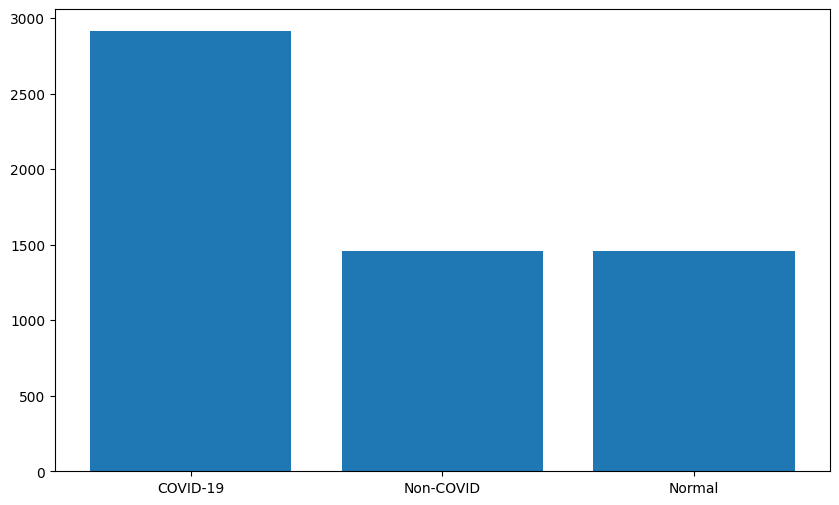

In [21]:
#Use the group by function on the class label column of the dataframe to check for class imbalance
image_group = df_processed_images.groupby(['Label']).count()
image_group

#Plot the grouped data in a bar chart to see the class balance
plt.figure(figsize=(10, 6))
bar_plot = plt.bar(x=image_group.index, height=image_group['overlayed_image_path'])

In [22]:
df_processed_images

,overlayed_image_path,Label
0,/kaggle/working/overlayed_images/overlayed_0.png,COVID-19
1,/kaggle/working/overlayed_images/overlayed_1.png,COVID-19
2,/kaggle/working/overlayed_images/overlayed_2.png,COVID-19
3,/kaggle/working/overlayed_images/overlayed_3.png,COVID-19
4,/kaggle/working/overlayed_images/overlayed_4.png,COVID-19
...,...,...
5821,/kaggle/working/overlayed_images/overlayed_170...,Normal
5822,/kaggle/working/overlayed_images/overlayed_170...,Normal
5823,/kaggle/working/overlayed_images/overlayed_170...,Normal
5824,/kaggle/working/overlayed_images/overlayed_170...,Normal


In [23]:
import os
import cv2
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Directory to save the augmented images
output_dir_augmented = '/kaggle/working/augmented_images'
os.makedirs(output_dir_augmented, exist_ok=True)

In [24]:
# List to store new data
augmented_data = []

# Function to augment images and store the paths and class labels
def augment_and_save_images(image_path, label, augment_count=5):
    print(f"Processing image: {image_path}")

    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image {image_path}")
        return

    if len(image.shape) == 2:  # If the image is grayscale
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    image = image.reshape((1,) + image.shape)  # Reshape image to match generator input shape

    i = 0
    for batch in datagen.flow(image, batch_size=1):
        augmented_image_path = os.path.join(output_dir_augmented, f"augmented_{label}_{i}.png")
        augmented_image = batch[0].astype('uint8')  # Convert from float to uint8 format
        cv2.imwrite(augmented_image_path, augmented_image)
        print(f"Saved: {augmented_image_path}")  # Debugging line

        augmented_data.append({
            'overlayed_image_path': augmented_image_path,
            'Label': label
        })

        i += 1
        if i >= augment_count:  # Stop after generating the desired number of augmentations
            break

In [ ]:
# Augment images for Non-COVID (1) and Normal (2) classes
minority_classes = ['Non-COVID', 'Normal']  # Non-COVID = 1, Normal = 2
augment_count_per_image = 1  # Number of augmentations per image

# Check if df_processed_images has valid paths
print(f"Checking DataFrame: {df_processed_images.head()}")

# Iterate through the minority class images
for index, row in df_processed_images.iterrows():
    if row['Label'] in minority_classes:
        print(f"Augmenting image {index} from class {row['Label']}")
        augment_and_save_images(row['overlayed_image_path'], row['Label'], augment_count=augment_count_per_image)

# Create a DataFrame from the augmented data
df_augmented = pd.DataFrame(augmented_data)

# Check if df_augmented is populated
print(f"Augmented Data: {df_augmented.head()}")

# Concatenate the augmented data to the original df_bounding_box_images
df_processed_images = pd.concat([df_processed_images, df_augmented], ignore_index=True)

# Check the updated DataFrame
print(f"Updated DataFrame: {df_processed_images.head()}")

Checking DataFrame:                                overlayed_image_path     Label
0  /kaggle/working/overlayed_images/overlayed_0.png  COVID-19
1  /kaggle/working/overlayed_images/overlayed_1.png  COVID-19
2  /kaggle/working/overlayed_images/overlayed_2.png  COVID-19
3  /kaggle/working/overlayed_images/overlayed_3.png  COVID-19
4  /kaggle/working/overlayed_images/overlayed_4.png  COVID-19
Augmenting image 583 from class Non-COVID
Processing image: /kaggle/working/overlayed_images/overlayed_1749.png
Saved: /kaggle/working/augmented_images/augmented_Non-COVID_0.png
Augmenting image 584 from class Non-COVID
Processing image: /kaggle/working/overlayed_images/overlayed_1750.png
Saved: /kaggle/working/augmented_images/augmented_Non-COVID_0.png
Augmenting image 585 from class Non-COVID
Processing image: /kaggle/working/overlayed_images/overlayed_1751.png
Saved: /kaggle/working/augmented_images/augmented_Non-COVID_0.png
Augmenting image 586 from class Non-COVID
Processing image: /kaggle/workin

In [34]:
df_processed_images

,overlayed_image_path,Label
0,/kaggle/working/overlayed_images/overlayed_0.png,0
1,/kaggle/working/overlayed_images/overlayed_1.png,0
2,/kaggle/working/overlayed_images/overlayed_2.png,0
3,/kaggle/working/overlayed_images/overlayed_3.png,0
4,/kaggle/working/overlayed_images/overlayed_4.png,0
...,...,...
8734,/kaggle/working/augmented_images/augmented_Nor...,2
8735,/kaggle/working/augmented_images/augmented_Nor...,2
8736,/kaggle/working/augmented_images/augmented_Nor...,2
8737,/kaggle/working/augmented_images/augmented_Nor...,2


In [ ]:
#Convert the class label to numerical using the replace function
df_processed_images['Label'] = df_processed_images['Label'].replace('COVID-19', 0)
df_processed_images['Label'] = df_processed_images['Label'].replace('Non-COVID', 1)
df_processed_images['Label'] = df_processed_images['Label'].replace('Normal', 2)

In [ ]:
# Load the processed images dataframe
df_processed_images = df_processed_images

# Splitting the dataset into training and temp (temporary split is used for further splitting into validation and test)
train_data, val_test_data = train_test_split(df_processed_images, test_size=0.2, stratify=df_processed_images['Label'], random_state=42)


# Further splitting the temp dataset into validation and test dataset
val_data, test_data = train_test_split(val_test_data, test_size=0.5, stratify=val_test_data['Label'], random_state=42)

In [ ]:
train_data

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
device = "cpu"  # Force CPU for training

In [39]:
import torch
from torchvision import models, transforms
from PIL import Image
import clip
import pandas as pd

# Device configuration
device = "cpu"  # Adjust this as needed

# Load the CLIP model
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# Pretrained ResNet18 for prompt generation
class ResNet18Prompt(torch.nn.Module):
    def __init__(self):
        super(ResNet18Prompt, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc = torch.nn.Linear(self.resnet18.fc.in_features, 512)  # Output a 512-d vector to match CLIP's embedding size

    def forward(self, x):
        x = self.resnet18(x)
        return x

# Initialize the ResNet18 model
resnet_prompt_model = ResNet18Prompt().to(device)

# Unfreeze all layers of ResNet18 for fine-tuning
for param in resnet_prompt_model.resnet18.parameters():
    param.requires_grad = True

# Define your dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['overlayed_image_path']
        label = self.dataframe.iloc[idx]['Label']  # Labels already numeric
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image, label

# Image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare datasets and dataloaders
train_dataset = CustomDataset(train_data, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

# Training loop
optimizer = torch.optim.Adam(resnet_prompt_model.parameters(), lr=0.00001)  # Reduced learning rate
loss_fn = torch.nn.CrossEntropyLoss()

def train_model(resnet_model, clip_model, train_loader, optimizer, loss_fn, epochs=10):
    resnet_model.train()
    clip_model.eval()  # CLIP is usually kept frozen
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Get features from ResNet18 (acting as learned prompts/condition)
            resnet_features = resnet_model(images)  # 512-d feature vector from ResNet18
            
            # Use CLIP's image encoder to encode the image
            clip_image_features = clip_model.encode_image(images)  # 512-d feature vector from CLIP
            
            # Add ResNet18 features to CLIP image features (Option 2)
            conditioned_image_features = clip_image_features + resnet_features  # Still a 512-d vector
            
            # Use CLIP model to get text features for classification
            text_prompts = clip.tokenize(["a photo of a COVID-19", "a photo of a Non-COVID", "a photo of a Normal"]).to(device)
            text_features = clip_model.encode_text(text_prompts)  # 3x512-d

            # Compute similarity between conditioned image features and text features
            logits_per_image = conditioned_image_features @ text_features.T

            # Calculate loss
            loss = loss_fn(logits_per_image, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

# Train the model
train_model(resnet_prompt_model, clip_model, train_loader, optimizer, loss_fn)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.9653070608284606
Epoch 2, Loss: 0.5629713508328188
Epoch 3, Loss: 0.5107669491849379
Epoch 4, Loss: 0.6194221341142802
Epoch 5, Loss: 0.718595820332044
Epoch 6, Loss: 0.7717678715140309
Epoch 7, Loss: 0.8302031746922696
Epoch 8, Loss: 0.3744250021542442
Epoch 9, Loss: 0.36800688749831384
Epoch 10, Loss: 0.37078618601782914


In [40]:
test_dataset = CustomDataset(test_data, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

SyntaxError: invalid syntax (4247744783.py, line 13)

In [41]:
import torch
from sklearn.metrics import accuracy_score

# Define the function to evaluate the model
def evaluate_model(resnet_model, clip_model, test_loader):
    resnet_model.eval()  # Set ResNet18 to evaluation mode
    clip_model.eval()    # Set CLIP model to evaluation mode (already frozen, but just in case)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No need to calculate gradients for evaluation
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get features from ResNet18
            resnet_features = resnet_model(images)  # 512-d feature vector from ResNet18
            
            # Use CLIP's image encoder to encode the image
            clip_image_features = clip_model.encode_image(images)  # 512-d feature vector from CLIP
            
            # Add ResNet18 features to CLIP image features (Option 2)
            conditioned_image_features = clip_image_features + resnet_features  # Still a 512-d vector
            
            # Use CLIP model to get text features for classification
            text_prompts = clip.tokenize(["a photo of a COVID-19", "a photo of a Non-COVID", "a photo of a Normal"]).to(device)
            text_features = clip_model.encode_text(text_prompts)  # 3x512-d
            
            # Compute similarity between conditioned image features and text features
            logits_per_image = conditioned_image_features @ text_features.T  # Similarity scores
            
            # Get the predicted class (highest similarity score)
            preds = torch.argmax(logits_per_image, dim=1)  # Get the index of the highest logit (predicted class)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy using sklearn's accuracy_score
    accuracy = accuracy_score(all_labels, all_preds)
    
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Prepare your test dataset and dataloader (similar to the train loader)
test_dataset = CustomDataset(test_data, transform=transform)  # Assuming you have a `test_data` dataframe
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate the model on test data
evaluate_model(resnet_prompt_model, clip_model, test_loader)

Test Accuracy: 91.08%


In [42]:
# Function to save the model
def save_model(resnet_model, clip_model, model_path_resnet="Covid_resnet_prompt_model.pth", model_path_clip="Covid_clip_model.pth"):
    # Save ResNet18 model state dictionary
    torch.save(resnet_model.state_dict(), model_path_resnet)
    
    # Save CLIP model state dictionary (optional if you have modified it, CLIP is usually kept frozen)
    # If you modified or fine-tuned the CLIP model, you can save it too
    torch.save(clip_model.state_dict(), model_path_clip)
    
    print(f"ResNet18 model saved to {model_path_resnet}")
    print(f"CLIP model saved to {model_path_clip}")

# Save the models
save_model(resnet_prompt_model, clip_model)

ResNet18 model saved to Covid_resnet_prompt_model.pth
CLIP model saved to Covid_clip_model.pth


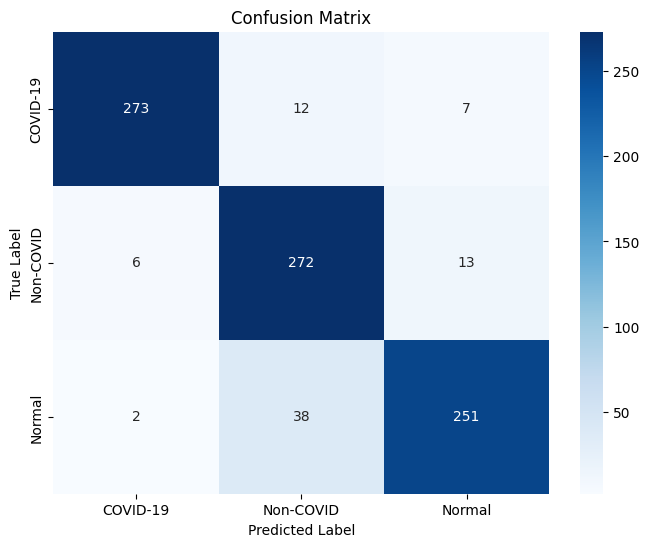

In [43]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate the model and build confusion matrix
def evaluate_and_confusion_matrix(resnet_model, clip_model, test_loader):
    resnet_model.eval()  # Set ResNet18 to evaluation mode
    clip_model.eval()    # Set CLIP model to evaluation mode
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No need to calculate gradients for evaluation
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get features from ResNet18
            resnet_features = resnet_model(images)  # 512-d feature vector from ResNet18
            
            # Use CLIP's image encoder to encode the image
            clip_image_features = clip_model.encode_image(images)  # 512-d feature vector from CLIP
            
            # Add ResNet18 features to CLIP image features (Option 2)
            conditioned_image_features = clip_image_features + resnet_features  # Still a 512-d vector
            
            # Use CLIP model to get text features for classification
            text_prompts = clip.tokenize(["a photo of a COVID-19", "a photo of a Non-COVID", "a photo of a Normal"]).to(device)
            text_features = clip_model.encode_text(text_prompts)  # 3x512-d
            
            # Compute similarity between conditioned image features and text features
            logits_per_image = conditioned_image_features @ text_features.T  # Similarity scores
            
            # Get the predicted class (highest similarity score)
            preds = torch.argmax(logits_per_image, dim=1)  # Get the index of the highest logit (predicted class)
            
            all_preds.extend(preds.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())  # Store true labels
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["COVID-19", "Non-COVID", "Normal"], 
                yticklabels=["COVID-19", "Non-COVID", "Normal"])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Prepare your test dataset and dataloader (similar to the train loader)
test_dataset = CustomDataset(test_data, transform=transform)  # Assuming you have a `test_data` dataframe
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Generate confusion matrix
evaluate_and_confusion_matrix(resnet_prompt_model, clip_model, test_loader)

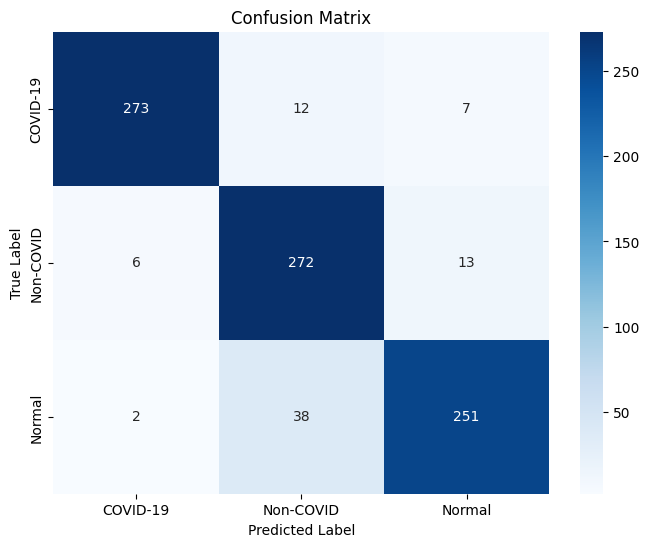

Classification Report:
               precision    recall  f1-score   support

    COVID-19       0.97      0.93      0.95       292
   Non-COVID       0.84      0.93      0.89       291
      Normal       0.93      0.86      0.89       291

    accuracy                           0.91       874
   macro avg       0.91      0.91      0.91       874
weighted avg       0.91      0.91      0.91       874



In [44]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate the model and build confusion matrix and classification report
def evaluate_and_report(resnet_model, clip_model, test_loader):
    resnet_model.eval()  # Set ResNet18 to evaluation mode
    clip_model.eval()    # Set CLIP model to evaluation mode
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No need to calculate gradients for evaluation
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get features from ResNet18
            resnet_features = resnet_model(images)  # 512-d feature vector from ResNet18
            
            # Use CLIP's image encoder to encode the image
            clip_image_features = clip_model.encode_image(images)  # 512-d feature vector from CLIP
            
            # Add ResNet18 features to CLIP image features (Option 2)
            conditioned_image_features = clip_image_features + resnet_features  # Still a 512-d vector
            
            # Use CLIP model to get text features for classification
            text_prompts = clip.tokenize(["a photo of a COVID-19", "a photo of a Non-COVID", "a photo of a Normal"]).to(device)
            text_features = clip_model.encode_text(text_prompts)  # 3x512-d
            
            # Compute similarity between conditioned image features and text features
            logits_per_image = conditioned_image_features @ text_features.T  # Similarity scores
            
            # Get the predicted class (highest similarity score)
            preds = torch.argmax(logits_per_image, dim=1)  # Get the index of the highest logit (predicted class)
            
            all_preds.extend(preds.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())  # Store true labels
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["COVID-19", "Non-COVID", "Normal"], 
                yticklabels=["COVID-19", "Non-COVID", "Normal"])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=["COVID-19", "Non-COVID", "Normal"])
    print("Classification Report:\n", report)

# Prepare your test dataset and dataloader (similar to the train loader)
test_dataset = CustomDataset(test_data, transform=transform)  # Assuming you have a `test_data` dataframe
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Generate confusion matrix and classification report
evaluate_and_report(resnet_prompt_model, clip_model, test_loader)

In [45]:
from sklearn.metrics import average_precision_score
import numpy as np

# Function to compute mAP for the model
def evaluate_mAP(resnet_model, clip_model, test_loader, num_classes=3):
    resnet_model.eval()  # Set ResNet18 to evaluation mode
    clip_model.eval()    # Set CLIP model to evaluation mode
    
    all_logits = []
    all_labels = []
    
    with torch.no_grad():  # No need to calculate gradients for evaluation
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get features from ResNet18
            resnet_features = resnet_model(images)  # 512-d feature vector from ResNet18
            
            # Use CLIP's image encoder to encode the image
            clip_image_features = clip_model.encode_image(images)  # 512-d feature vector from CLIP
            
            # Add ResNet18 features to CLIP image features
            conditioned_image_features = clip_image_features + resnet_features  # Still a 512-d vector
            
            # Use CLIP model to get text features for classification
            text_prompts = clip.tokenize(["a photo of a COVID-19", "a photo of a Non-COVID", "a photo of a Normal"]).to(device)
            text_features = clip_model.encode_text(text_prompts)  # 3x512-d
            
            # Compute similarity between conditioned image features and text features
            logits_per_image = conditioned_image_features @ text_features.T  # Similarity scores
            
            # Store logits and true labels
            all_logits.append(logits_per_image.cpu().numpy())  # Store logits (unnormalized prediction scores)
            all_labels.append(labels.cpu().numpy())  # Store true labels
    
    # Convert to numpy arrays
    all_logits = np.concatenate(all_logits, axis=0)  # Shape: (num_samples, num_classes)
    all_labels = np.concatenate(all_labels, axis=0)  # Shape: (num_samples,)

    # Convert labels to one-hot encoding for multi-class mAP calculation
    all_labels_one_hot = np.eye(num_classes)[all_labels]  # Shape: (num_samples, num_classes)

    # Compute Average Precision (AP) for each class
    ap_per_class = []
    for i in range(num_classes):
        ap = average_precision_score(all_labels_one_hot[:, i], all_logits[:, i])
        ap_per_class.append(ap)
        print(f"AP for class {i}: {ap:.4f}")

    # Compute mean Average Precision (mAP)
    mAP = np.mean(ap_per_class)
    print(f"Mean Average Precision (mAP): {mAP:.4f}")

    return mAP

# Prepare your test dataset and dataloader (similar to the train loader)
test_dataset = CustomDataset(test_data, transform=transform)  # Assuming you have a `test_data` dataframe
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate mAP
evaluate_mAP(resnet_prompt_model, clip_model, test_loader)

AP for class 0: 0.8421
AP for class 1: 0.9516
AP for class 2: 0.9459
Mean Average Precision (mAP): 0.9132


0.9132011889836983

/tmp/ipykernel_30/2667741401.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_prompt_model.load_state_dict(torch.load("/kaggle/working/Covid_resnet_prompt_model.p

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


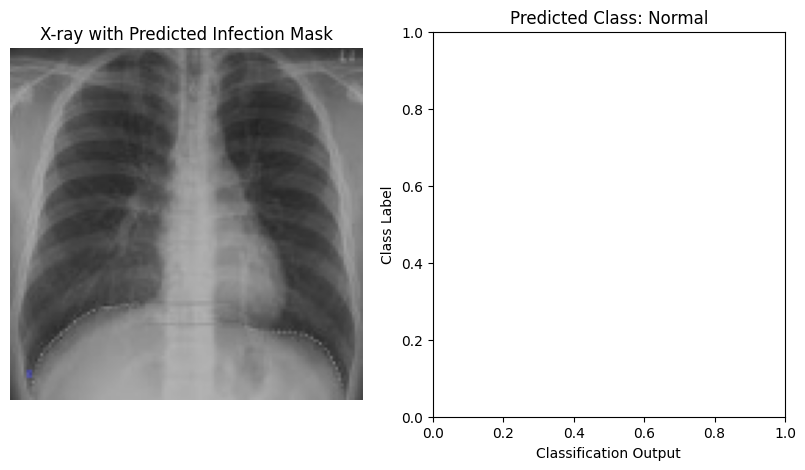

Predicted Class: Normal


In [64]:
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import clip

# Device configuration
device = torch.device('cpu')  # Adjust as needed

# Load your pre-trained CLIP model (architecture must be initialized before loading state_dict)
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# Rebuild your ResNet18-based model architecture
class ResNet18Prompt(nn.Module):
    def __init__(self):
        super(ResNet18Prompt, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, 512)  # Output a 512-d vector to match CLIP's embedding size

    def forward(self, x):
        x = self.resnet18(x)
        return x

# Instantiate the ResNet18 model
resnet_prompt_model = ResNet18Prompt().to(device)

# Load the state dictionaries
resnet_prompt_model.load_state_dict(torch.load("/kaggle/working/Covid_resnet_prompt_model.pth", map_location=device))
clip_model.load_state_dict(torch.load("/kaggle/working/Covid_clip_model.pth", map_location=device))

# Set both models to evaluation mode
resnet_prompt_model.eval()
clip_model.eval()

# Load the pre-trained U-Net model for segmentation
unet_model = load_model("/kaggle/working/covid_unet_segmentation_model.h5")

# Step 1: Predict segmentation mask using U-Net
def predict_segmentation(image_path, img_height=128, img_width=128):
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    preprocessed_image = cv2.resize(original_image, (img_height, img_width))
    preprocessed_image = np.expand_dims(preprocessed_image, axis=(0, -1))  # Add batch and channel dimensions
    preprocessed_image = preprocessed_image / 255.0  # Normalize

    predicted_mask = unet_model.predict(preprocessed_image)
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Threshold to binary
    predicted_mask = np.squeeze(predicted_mask)  # Remove batch dimension

    return predicted_mask

# Step 2: Overlay predicted mask on original X-ray
def superimpose_mask_on_xray(original_image, predicted_mask):
    original_image_resized = cv2.resize(original_image, (predicted_mask.shape[1], predicted_mask.shape[0]))
    original_image_rgb = cv2.cvtColor(original_image_resized, cv2.COLOR_GRAY2RGB)
    mask_rgb = np.zeros_like(original_image_rgb)
    mask_rgb[:, :, 2] = predicted_mask * 255  # Use the blue color for the mask
    superimposed_image = cv2.addWeighted(original_image_rgb, 0.7, mask_rgb, 0.3, 0)
    
    return superimposed_image

# Step 3: Classify the superimposed image using ResNet + CLIP
def classify_superimposed_image_with_resnet_clip(image_path):
    # Step 1: Predict Infection Mask and Superimpose
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if original_image is None:
        print(f"Error: Could not read the image file '{image_path}'.")
        return
    
    predicted_mask = predict_segmentation(image_path)
    overlayed_image = superimpose_mask_on_xray(original_image, predicted_mask)

    # Step 2: Convert overlayed image to PIL format for classification
    overlayed_image_pil = Image.fromarray(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))

    # Step 3: Preprocess the image for ResNet + CLIP model
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    overlayed_image_tensor = transform(overlayed_image_pil).unsqueeze(0)  # Add batch dimension
    
    # Step 4: Get features from ResNet18 and CLIP
    with torch.no_grad():
        resnet_features = resnet_prompt_model(overlayed_image_tensor)  # Get ResNet18 features
        
        # Use CLIP's image encoder to encode the image
        clip_image_features = clip_model.encode_image(overlayed_image_tensor)  # 512-d feature vector from CLIP
        
        # Add ResNet18 features to CLIP image features (conditioning)
        conditioned_image_features = clip_image_features + resnet_features  # Still a 512-d vector
        
        # Use CLIP model to get text features for classification
        text_prompts = clip.tokenize(["a photo of a COVID-19", "a photo of a Non-COVID", "a photo of a Normal"]).to(device)
        text_features = clip_model.encode_text(text_prompts)  # 3x512-d
    
        # Compute similarity between conditioned image features and text features
        logits_per_image = conditioned_image_features @ text_features.T  # Similarity scores
    
    # Step 5: Get the predicted class
    predicted_class = torch.argmax(logits_per_image[0], dim=0).item()  # Get the class with the highest logit score
    classes = ["COVID-19", "Non-COVID", "Normal"]

    # Step 6: Show the overlayed image and print the classification result
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("X-ray with Predicted Infection Mask")
    plt.imshow(overlayed_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Predicted Class: {classes[predicted_class]}")
    plt.ylabel("Class Label")
    plt.xlabel("Classification Output")
    plt.show()

    return classes[predicted_class]

# Example usage of the complete pipeline
image_path = "/kaggle/input/normal/download.jpeg"  # Replace with your test image path
predicted_class = classify_superimposed_image_with_resnet_clip(image_path)
print(f"Predicted Class: {predicted_class}")

/tmp/ipykernel_30/3369470600.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_prompt_model.load_state_dict(torch.load("/kaggle/working/Covid_resnet_prompt_model.p

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


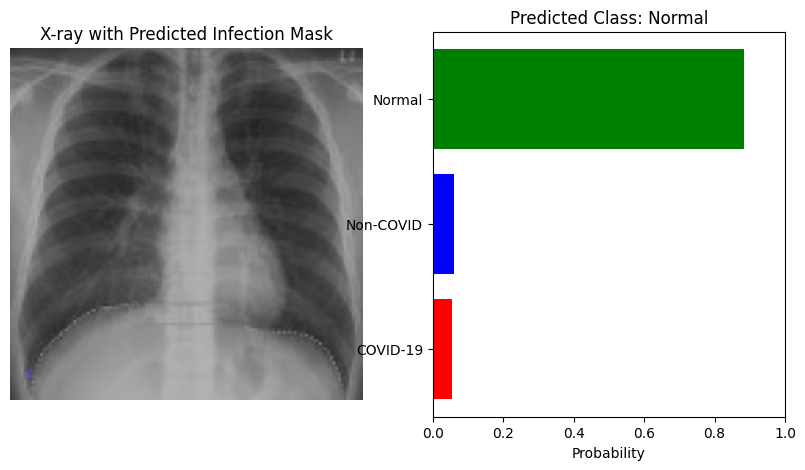

Predicted Class: Normal


In [65]:
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import clip

# Device configuration
device = torch.device('cpu')  # Adjust as needed

# Load your pre-trained CLIP model (architecture must be initialized before loading state_dict)
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# Rebuild your ResNet18-based model architecture
class ResNet18Prompt(nn.Module):
    def __init__(self):
        super(ResNet18Prompt, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, 512)  # Output a 512-d vector to match CLIP's embedding size

    def forward(self, x):
        x = self.resnet18(x)
        return x

# Instantiate the ResNet18 model
resnet_prompt_model = ResNet18Prompt().to(device)

# Load the state dictionaries
resnet_prompt_model.load_state_dict(torch.load("/kaggle/working/Covid_resnet_prompt_model.pth", map_location=device))
clip_model.load_state_dict(torch.load("/kaggle/working/Covid_clip_model.pth", map_location=device))

# Set both models to evaluation mode
resnet_prompt_model.eval()
clip_model.eval()

# Load the pre-trained U-Net model for segmentation
unet_model = load_model("/kaggle/working/covid_unet_segmentation_model.h5")

# Step 1: Predict segmentation mask using U-Net
def predict_segmentation(image_path, img_height=128, img_width=128):
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    preprocessed_image = cv2.resize(original_image, (img_height, img_width))
    preprocessed_image = np.expand_dims(preprocessed_image, axis=(0, -1))  # Add batch and channel dimensions
    preprocessed_image = preprocessed_image / 255.0  # Normalize

    predicted_mask = unet_model.predict(preprocessed_image)
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Threshold to binary
    predicted_mask = np.squeeze(predicted_mask)  # Remove batch dimension

    return predicted_mask

# Step 2: Overlay predicted mask on original X-ray
def superimpose_mask_on_xray(original_image, predicted_mask):
    original_image_resized = cv2.resize(original_image, (predicted_mask.shape[1], predicted_mask.shape[0]))
    original_image_rgb = cv2.cvtColor(original_image_resized, cv2.COLOR_GRAY2RGB)
    mask_rgb = np.zeros_like(original_image_rgb)
    mask_rgb[:, :, 2] = predicted_mask * 255  # Use the blue color for the mask
    superimposed_image = cv2.addWeighted(original_image_rgb, 0.7, mask_rgb, 0.3, 0)
    
    return superimposed_image

# Step 3: Classify the superimposed image using ResNet + CLIP
def classify_superimposed_image_with_resnet_clip(image_path):
    # Step 1: Predict Infection Mask and Superimpose
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if original_image is None:
        print(f"Error: Could not read the image file '{image_path}'.")
        return
    
    predicted_mask = predict_segmentation(image_path)
    overlayed_image = superimpose_mask_on_xray(original_image, predicted_mask)

    # Step 2: Convert overlayed image to PIL format for classification
    overlayed_image_pil = Image.fromarray(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))

    # Step 3: Preprocess the image for ResNet + CLIP model
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    overlayed_image_tensor = transform(overlayed_image_pil).unsqueeze(0)  # Add batch dimension
    
    # Step 4: Get features from ResNet18 and CLIP
    with torch.no_grad():
        resnet_features = resnet_prompt_model(overlayed_image_tensor)  # Get ResNet18 features
        
        # Use CLIP's image encoder to encode the image
        clip_image_features = clip_model.encode_image(overlayed_image_tensor)  # 512-d feature vector from CLIP
        
        # Add ResNet18 features to CLIP image features (conditioning)
        conditioned_image_features = clip_image_features + resnet_features  # Still a 512-d vector
        
        # Use CLIP model to get text features for classification
        text_prompts = clip.tokenize(["a photo of a COVID-19", "a photo of a Non-COVID", "a photo of a Normal"]).to(device)
        text_features = clip_model.encode_text(text_prompts)  # 3x512-d
    
        # Compute similarity between conditioned image features and text features
        logits_per_image = conditioned_image_features @ text_features.T  # Similarity scores
    
    # Step 5: Convert logits to probabilities using softmax
    probabilities = torch.nn.functional.softmax(logits_per_image[0], dim=0).cpu().numpy()  # Convert logits to probabilities

    # Step 6: Get the predicted class
    predicted_class = np.argmax(probabilities)  # Get the class with the highest probability
    classes = ["COVID-19", "Non-COVID", "Normal"]

    # Step 7: Plot the image and the probabilities
    plt.figure(figsize=(10, 5))

    # Plot the superimposed image
    plt.subplot(1, 2, 1)
    plt.title("X-ray with Predicted Infection Mask")
    plt.imshow(overlayed_image)
    plt.axis('off')

    # Plot the class probabilities as a bar chart
    plt.subplot(1, 2, 2)
    plt.title(f"Predicted Class: {classes[predicted_class]}")
    plt.barh(classes, probabilities, color=['red', 'blue', 'green'])
    plt.xlim(0, 1)  # Probability values range from 0 to 1
    plt.xlabel("Probability")

    plt.show()

    return classes[predicted_class]

# Example usage of the complete pipeline
image_path = "/kaggle/input/normal/download.jpeg"  # Replace with your test image path
predicted_class = classify_superimposed_image_with_resnet_clip(image_path)
print(f"Predicted Class: {predicted_class}")